In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score
import os
import pickle
from dotenv import load_dotenv
from preprocess import preprocess
import numpy as np

load_dotenv(override=True)

True

In [2]:
dat = pd.read_parquet(os.getenv('TEST_PARQUET'))
dat.shape

(2867, 432)

In [3]:
preprocess(dat, split='train')
dat.shape

dropping 26 of census tract columns
found columns with NaN: bmi, NaN number = 86, dropping these patients
found columns with NaN: mother_age, NaN number = 11, dropping these patients
found columns with NaN: mother_height, NaN number = 132, dropping these patients
found columns with NaN: smoking, NaN number = 1, dropping these patients
found columns with NaN: tobacco, NaN number = 1, dropping these patients
removing patients without prenatal and postpartum visit 272
dropping columns: counts_of_visits_3m_after_delivery, counts_of_visits_6m_after_delivery


(2443, 405)

In [4]:
with open(os.getenv("ML_MODEL"), 'rb') as fid:
    clf = pickle.load(fid)

c:\Users\zhma\Projects\ammi\analysis\zhma_ml_analysis\.venv\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\zhma\Projects\ammi\analysis\zhma_ml_analysis\.venv\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
# prepare the X, y
X = dat.drop(columns=['F53_label','edinburgh_max','phq9_total_max', 'birthid', 'PPD_delete_label'])
y = np.where( (dat['edinburgh_max'] >= 10) | 
              (dat['phq9_total_max'] >= 10) | 
              (dat['F53_label'] == 1), 1, 0)

In [6]:
# make prediction
y_pred = clf.predict(X)
y_pred_prob = clf.predict_proba(X)

In [7]:
# get various score
print('auc= {0:.3f}'.format(roc_auc_score(y, y_pred_prob[:, 1])))
print('specificity= {0:.3f}'.format(recall_score(y, y_pred, pos_label=0)))
print('sensitivity= {0:.3f}'.format(recall_score(y, y_pred)))

auc= 0.747
specificity= 0.897
sensitivity= 0.413


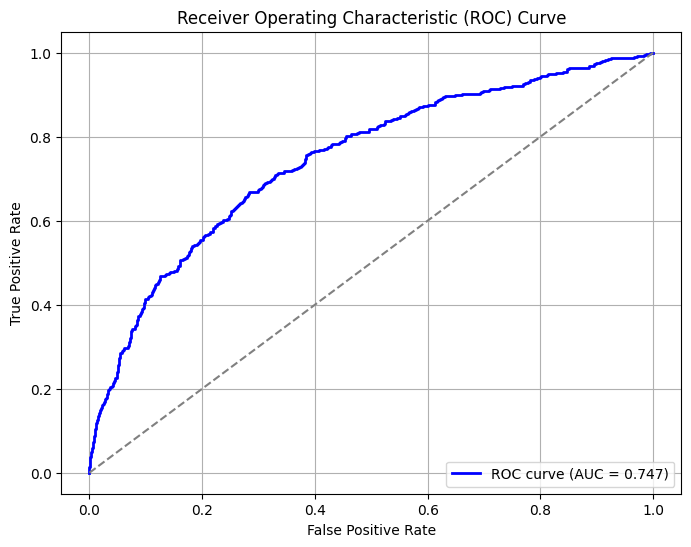

In [8]:
# make a plot for AUC curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Assuming y_pred_prob and y are your predicted probabilities and true labels
# y_pred_prob: predicted probabilities for the positive class
# y: true labels (binary: 0 or 1)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y, y_pred_prob[:, 1]):.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [9]:
# we are particularly interested in performance among different races
# if this is run only a subset, it may not be robust as there will only be a few hundred patient in the minority group
race_cols = ['mother_is_black', 'mother_is_hispanic', 'mother_is_white']
for col in race_cols:
    idx = (X[col] == 1)
    y_selected = y[idx]
    y_pred_selected = y_pred[idx]
    y_pred_prob_selected = y_pred_prob[idx]
    print(f"====== for {col}: ======")
    print("N={0} positive rate = {1:.3f}".format(len(y_selected), y_selected.mean()))
    print('auc= {0:.3f}'.format(roc_auc_score(y_selected, y_pred_prob_selected[:, 1])))
    print('specificity= {0:.3f}'.format(recall_score(y_selected, y_pred_selected, pos_label=0)))
    print('sensitivity= {0:.3f}'.format(recall_score(y_selected, y_pred_selected)))

====== for mother_is_black: ======
N=538 positive rate = 0.167
auc= 0.703
specificity= 0.875
sensitivity= 0.456
====== for mother_is_hispanic: ======
N=452 positive rate = 0.077
auc= 0.779
specificity= 0.954
sensitivity= 0.314
====== for mother_is_white: ======
N=1211 positive rate = 0.194
auc= 0.737
specificity= 0.873
sensitivity= 0.430
